In [1]:
import numpy as np
import torch
import tifffile as tiff
from pathlib import Path
from skimage.filters import gaussian
from skimage.morphology import remove_small_objects, dilation, disk
from skimage.measure import label, regionprops_table
from skimage.filters import threshold_otsu
from skimage.segmentation import watershed, relabel_sequential
from functools import reduce
from scipy import ndimage as ndi
import pandas as pd
from instanseg import InstanSeg
import matplotlib.pyplot as plt

In [2]:
from pathlib import Path

dir_path = Path().resolve()
dir_path

PosixPath('/mnt/ldata/Sadegh/my_codes/nencki-image-segmentation/notebooks')

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")
instanseg_fluorescence = InstanSeg("fluorescence_nuclei_and_cells", verbosity=1, device=device)

Using device: cuda
Model fluorescence_nuclei_and_cells version 0.1.0 downloaded and extracted to /mnt/ldata/Sadegh/my_codes/nencki-image-segmentation/venv/lib/python3.10/site-packages/instanseg/utils/../bioimageio_models/


In [4]:
WSI_PATH = dir_path.parent / 'image/pHGG_1991_3149_Scan1-001.qptiff'
USE_GPU = torch.cuda.is_available()
TILE = 512
OVERLAP = 128
BATCH_SIZE = 40

In [5]:
tf = tiff.TiffFile(WSI_PATH)
series = tf.series[0]
arr = series.asarray(out="memmap")
if arr.ndim == 3 and arr.shape[0] < arr.shape[-1]:
    C, H, W = arr.shape
else:
    arr = np.moveaxis(arr, -1, 0)
    C, H, W = arr.shape

In [6]:
arr.shape

(30, 64800, 36480)

### Cell segmentation based on the Just DAPI (channel 0)

In [7]:
arr[0]

memmap([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], shape=(64800, 36480), dtype=uint8)

In [8]:
labeled_output, image_tensor = instanseg_fluorescence.eval_medium_image(
    arr[0],
    pixel_size=None,
    target="cells",
    tile_size=TILE, 
    batch_size=BATCH_SIZE
)

/mnt/ldata/Sadegh/my_codes/nencki-image-segmentation/venv/lib/python3.10/site-packages/instanseg/inference_class.py:479: UserWarning: Pixel size not provided, this may lead to innacurate results.
  warnings.warn("Pixel size not provided, this may lead to innacurate results.")
/mnt/ldata/Sadegh/my_codes/nencki-image-segmentation/venv/lib/python3.10/site-packages/instanseg/utils/pytorch_utils.py:204: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at /pytorch/aten/src/ATen/SparseCsrTensorImpl.cpp:53.)
  intersection = torch.sparse.mm(onehot1, onehot2.T).to_dense()


In [9]:
print(type(labeled_output), getattr(labeled_output, 'shape', None))
print(type(image_tensor),  getattr(image_tensor,  'shape', None))
print(getattr(labeled_output, 'dtype', None), getattr(image_tensor, 'dtype', None))

<class 'torch.Tensor'> torch.Size([1, 1, 64800, 36480])
<class 'torch.Tensor'> torch.Size([1, 1, 64800, 36480])
torch.float32 torch.float32


In [10]:
img = image_tensor.squeeze().detach().cpu().numpy()

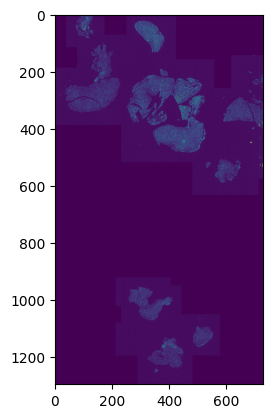

In [11]:
plt.imshow(img[::50, ::50])   # 50x downsample
plt.show()

In [12]:
labeled_output = labeled_output.squeeze().detach().cpu().numpy().astype("int32")

In [13]:
props = regionprops_table(
    labeled_output,
    intensity_image=arr[0],
    properties=("label", "centroid", "area", "perimeter","mean_intensity")
)

# label = cell id , centroid = center of cell, area and primeter = shape of cell, mean_intensity
# Run for each channel
cells_df = pd.DataFrame(props)
print(len(cells_df))

353600


In [14]:
cells_df.head(20)

,label,centroid-0,centroid-1,area,perimeter,mean_intensity
0,1,67.986928,4181.823529,153.0,43.798990,62.509804
1,2,70.042254,4098.859155,142.0,44.384776,44.140845
2,3,75.725000,4118.808333,120.0,39.213203,30.483333
3,4,91.783251,4105.231527,203.0,57.698485,31.517241
4,5,110.036630,4129.128205,273.0,61.355339,87.571429
5,6,111.382353,4152.650000,340.0,69.597980,71.941176
6,7,114.620253,4233.670886,79.0,31.556349,225.936709
7,8,118.295455,4084.627273,220.0,53.798990,52.090909
8,9,119.541176,4141.564706,85.0,33.798990,49.894118
9,10,123.225225,4238.333333,111.0,38.384776,58.441441


### Summarization for All Channel

In [ ]:
def extract_cell_features(labeled_output, arr, channel_names=None):
    """
    Parameters
    ----------
    labeled_output : ndarray (H, W)
        Segmentation mask, each cell has unique integer ID.
    arr : ndarray (C, H, W)
        Multi-channel image (channels, height, width).
    channel_names : list of str
        Names of channels in arr, e.g. ["DAPI","CD68","TMEM119","SPP1"].
        If None, channels will be named ch0, ch1, ...
    
    Returns
    -------
    DataFrame with per-cell features (like QuPath export).
    """
    if channel_names is None:
        channel_names = [f"ch{i}" for i in range(arr.shape[0])]

    results = []

    # --- morphology (independent of intensity) ---
    props_morph = regionprops_table(
        labeled_output,
        properties=("label", "centroid", "area", "perimeter")
    )
    df = pd.DataFrame(props_morph)
    df.rename(columns={"centroid-0": "Centroid Y µm",
                       "centroid-1": "Centroid X µm",
                       "area": "Cell: Area (px)",
                       "perimeter": "Cell: Perimeter (px)"}, inplace=True)
    results.append(df)

    # --- intensity per channel ---
    for i, ch in enumerate(channel_names):
        props = regionprops_table(
            labeled_output,
            intensity_image=arr[i],
            properties=("label", "mean_intensity", "median_intensity")
        )
        df_ch = pd.DataFrame(props).rename(
            columns={
                "mean_intensity": f"Cell: {ch}: Mean",
                "median_intensity": f"Cell: {ch}: Median"
            }
        )
        results.append(df_ch)

    # --- merge all on "label" ---
    features_df = reduce(lambda left, right: pd.merge(left, right, on="label"), results)
    return features_df

# -------------------------
# Example usage:
# labeled_output: (H,W)
# arr: (C,H,W)
# channel_names = ["DAPI", "GFAP", "CD45", "TMEM119", "HLA-DR", "CD68", "SPP1"]

features_df = extract_cell_features(labeled_output, arr, channel_names)
print(features_df.head())
